In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import cv2
import random
import numpy as np
import json

In [2]:
drive_log_df = pd.read_csv('./data/driving_log.csv')
drive_log_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


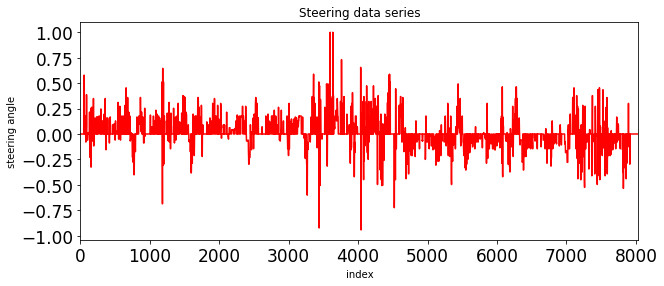

In [3]:
drive_log_df.steering.plot(title='Steering data series', fontsize=17, figsize=(10,4), color= 'r')
plt.xlabel('index')
plt.ylabel('steering angle')
plt.show()

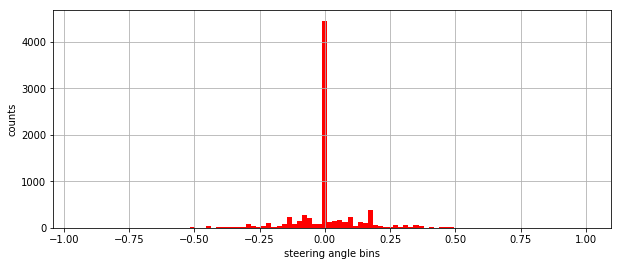

Dataset size 8036


In [4]:
def visualize_dataset_distribution(df):
    plt.figure(figsize=(10, 4))
    df.steering.hist(bins=100, color='r')
    plt.xlabel("steering angle bins")
    plt.ylabel("counts")
    plt.show()
    print("Dataset size", len(df.steering.index))
visualize_dataset_distribution(drive_log_df)

In [5]:
# minor_steering_df = drive_log_df[drive_log_df.steering.abs() < 0.05].sample(frac=0.8)
minor_steering_df = drive_log_df[drive_log_df.steering == 0].sample(frac=0.9)
resample_drive_df = drive_log_df.drop(minor_steering_df.index)

In [6]:
# visualize_dataset_distribution(resample_drive_df)

## Data Augmentation

In [7]:
def aug_l_c_r_df(df, correction = 0.25):
    """
    shift: column is used for image affine transformation
    """
    new_data = []
    for it, row in df.iterrows():
        steering = row.steering
        new_data.append({
            'image': row.left,
            'steering': np.clip(steering + correction, -1, 1),
            'is_flipped': False
        })
        
        new_data.append({
            'image': row.center,
            'steering': steering,
            'is_flipped': False
        })
        
        new_data.append({
            'image': row.right,
            'steering': np.clip(steering - correction, -1, 1),
            'is_flipped': False
        })
    
    return pd.DataFrame(new_data, columns=('image', 'steering', 'is_flipped'))

In [8]:
def aug_flip(df):
    flip_df = df[df.steering.abs() > 0.07].sample(frac=0.5)
#     flip_df = df[df.steering != 0].sample(frac=0.4)
    flip_df.loc[:, 'is_flipped'] = True
    flip_df.loc[:, 'steering'] = -flip_df.loc[:, 'steering']
#     return flip_df
    return pd.concat([df, flip_df])


In [9]:
# aug_drive_df = aug_l_c_r_df(resample_drive_df)
# flipped_df = aug_flip(aug_drive_df)
# visualize_dataset_distribution(flipped_df)

# flipped_df.head()
# flipped_df.tail()


In [10]:
def get_random():
#     (b - a) * np.random.random_sample() + a
    return (-1 - 1) * np.random.random_sample() + 1

def shift_to_steer_input(shift, max_steer):
    """
    steer -1, 1
    """
    return shift * max_steer

MAX_SHIFT = 0.3

def shift_image(df):
    df.loc[:, 'tx'] = 0
    new_df = df[df.steering != 0].copy()
    new_df.loc[:, 'tx'] = 0.0
    
    
    def update_row_steering(row):
        row.tx = get_random()
        row.steering = row.steering + row.tx * shift_to_steer_input(row.tx, MAX_SHIFT)
        row.steering = np.clip(row.steering, -1, 1)
        return row
    
    new_df = new_df.apply(update_row_steering, axis=1)
    return pd.concat([df, new_df])

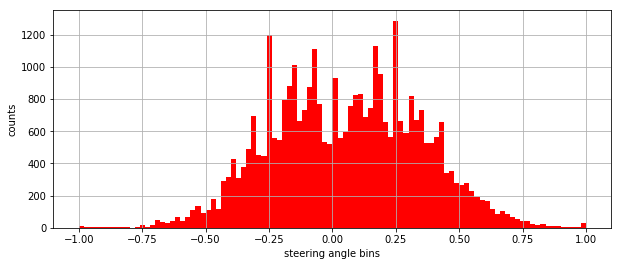

Dataset size 34474


In [11]:
def process_driver_log(df):
    _df = aug_l_c_r_df(df)
    _df = aug_flip(_df)
    _df = shift_image(_df)
    return _df

processed_driver_log = process_driver_log(resample_drive_df)
visualize_dataset_distribution(processed_driver_log)

In [12]:
# processed_driver_log.reset_index(inplace=True)
# processed_driver_log.head()
processed_driver_log.head()

,image,steering,is_flipped,tx
0,IMG/left_2016_12_01_13_31_13_584.jpg,0.25,False,0.0
1,IMG/center_2016_12_01_13_31_13_584.jpg,0.00,False,0.0
2,IMG/right_2016_12_01_13_31_13_584.jpg,-0.25,False,0.0
3,IMG/left_2016_12_01_13_31_13_890.jpg,0.25,False,0.0
4,IMG/center_2016_12_01_13_31_13_890.jpg,0.00,False,0.0


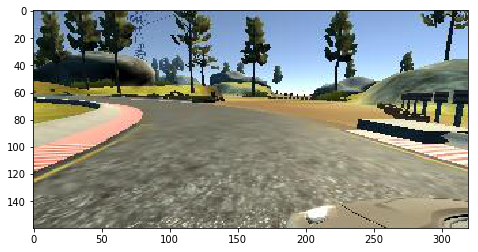

In [13]:
import matplotlib.image as mpimg
plt.figure(figsize=(10, 4))
row_0 = processed_driver_log.iloc[0]
image_path = row_0.image.strip()
image = mpimg.imread("./data/{0}".format(image_path))
plt.imshow(image)
plt.show()


## Image utilities

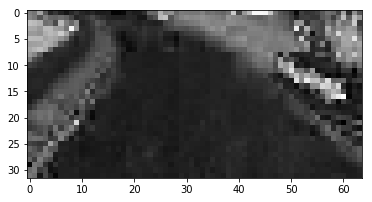

In [14]:
def color_select(image):
    """
    Only takes S channel
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:, :, 1]

def crop_image(image, ROI=(65, 125), size=(64, 32)):
    """
    Restrict ROI
    """
    return cv2.resize(image[ROI[0]: ROI[1]], size, cv2.INTER_AREA)

def flip_image(image):
    return cv2.flip(image, 1)

def translate_image(image, tx):
    """
    Affine/ translation only
    http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html
    """
    rows = image.shape[0]
    cols = image.shape[1]
    M = np.float32([[1,0,tx],[0,1,0]])
    return cv2.warpAffine(image,M,(cols, rows))

plt.figure(figsize=(6, 6))
plt.imshow(crop_image(color_select(image)), cmap='gray')
plt.show()


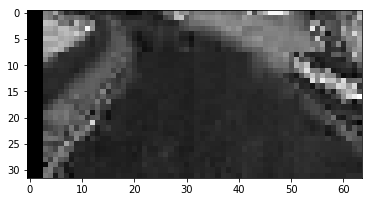

(160, 320, 3)


In [15]:
plt.figure(figsize=(6, 6))
plt.imshow(crop_image(color_select(translate_image(image, 15))), cmap='gray')
plt.show()

print(image.shape)

## Build the model

In [16]:
# def load_image(img):
#     return crop_image(color_select(translate_image(img, 15)))
def load_image_with_path(row):
    img = mpimg.imread("./data/{0}".format(row.image.strip()))
    if row.is_flipped:
        img = flip_image(img)
    if row.tx != 0:
        img = translate_image(img, row.tx)
    return crop_image(color_select(img))

def load_all_features_and_labels(df):
    images = [load_image_with_path(row) for _, row in df.iterrows()]
#     return images, df.steering
    return np.array(images).reshape((len(images), 32, 64, 1)), df.steering

In [17]:
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, ELU, BatchNormalization, Lambda, merge, MaxPooling2D, Input, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D, Conv2D
# from keras.utils.visualize_util import plot
from keras.optimizers import Adam
from keras.callbacks import Callback, RemoteMonitor
import keras.backend as K

Using TensorFlow backend.


In [19]:
model = Sequential()
# mean shift
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(32,64,1)))
model.add(Conv2D(2, 3, 3, border_mode='valid', input_shape=(32, 64, 1), activation='relu'))
model.add(MaxPooling2D((4, 4), (4, 4), 'valid'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(lr=1e-3), loss='mse')

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 32, 64, 1)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 62, 2)     20          lambda_2[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 7, 15, 2)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 7, 15, 2)      0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## Training

In [ ]:
features, labels = load_all_features_and_labels(processed_driver_log)
# h = model.fit(x=features,y=labels,verbose=1,batch_size=128,nb_epoch=50,validation_split=0.3)
h = model.fit(x=features,y=labels,verbose=1,batch_size=128,nb_epoch=15,validation_split=0.3)

In [ ]:
# a = load_all_features_and_labels(processed_driver_log)
# features.shape

In [ ]:
import gc;
gc.collect()
# filename = 'model'#"squeezemodel{0}".format(squeezemodel.count_params())
import json
model_json = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(model_json, outfile)
# Take a look at evalute_generator
model.save('model.h5')
print("Saved model")

In [ ]:
# model.summary()